# Experiment plotting

This notebook contains the code for plotting results for several simulations.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.plot import Plotter
import pandas as pd
import pickle
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases

In [3]:
places = [('GER', 'TU'), ('GER', 'RH'), ('GER', 'KL'), ('CH', 'TI'), ('CH', 'BE'), ('CH', 'JU')]
ymax_counterfactual = {'CH' : {'TI': 10000, 'BE': 50000, 'JU': 40000},
        'GER': {'TU': 30000, 'KL': 3000, 'RH': 4000}}
ymax_modelfit = {'GER': {'TU': 1200, 'KL': 800, 'RH': 1000, 'TR': 2000,},
                 'CH': {'VD': 2000, 'BE': 600, 'TI': 500, 'JU': 500,}}

## Model fit

In [4]:
def plot_model_fit(country, area, ymax_modelfit):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'model-fit-{country}-{area}' : [
            Plot(label='COVID-19 simulated case data', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
        ],
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        end_date = calibration_lockdown_dates[sims[0].country]['end']

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        mob_settings_paths = calibration_mob_paths[sims[0].country][sims[0].area][1]
        with open(mob_settings_paths, 'rb') as fp:
            mob_settings = pickle.load(fp)

        area_cases = collect_data_from_df(country=country,
             area=area,
             datatype='new',
             start_date_string=start_date,
             end_date_string=end_date)

        sim_cases = downsample_cases(area_cases, mob_settings)      # only downscaling due LK data for cities

        plotter.plot_positives_vs_target(
            summaries, labels,
            sim_cases.sum(axis=1),
            title='Calibration period',
            filename=plot_filename + '-modelfit',
            figsize=(6, 4),
            start_date=start_date,
            errorevery=1, acc=1000,
            ymax=ymax_modelfit[sims[0].country][sims[0].area]
        )


GER TU


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


GER RH
GER KL
CH TI
CH BE
CH JU


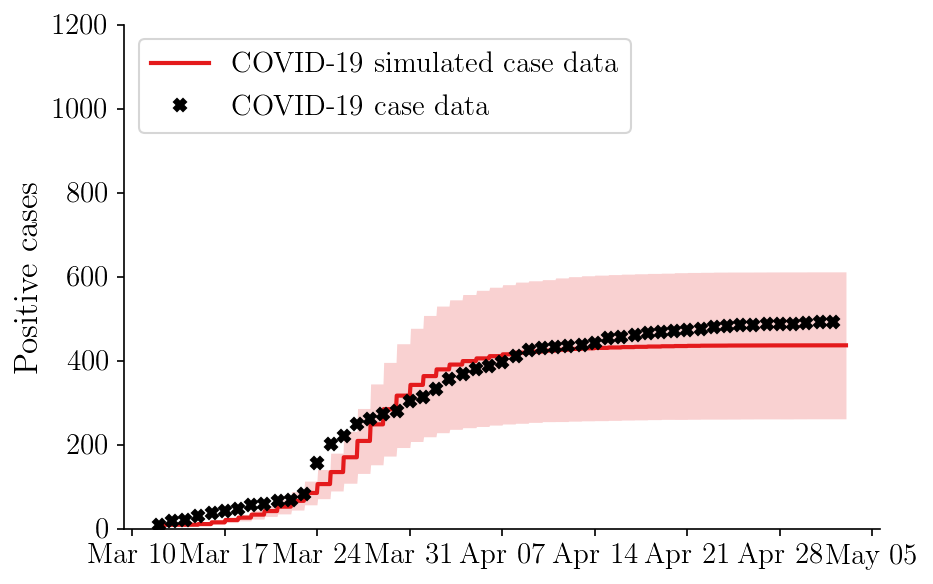

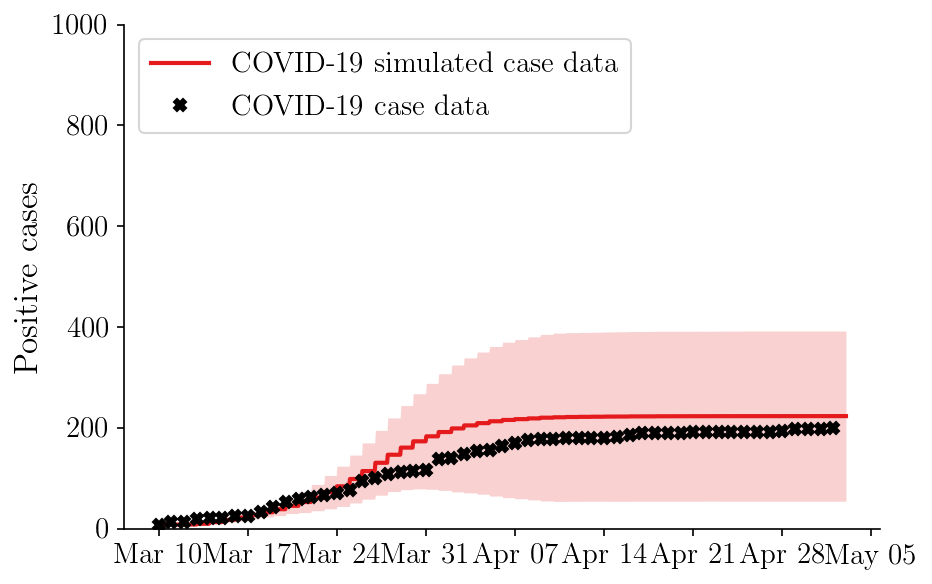

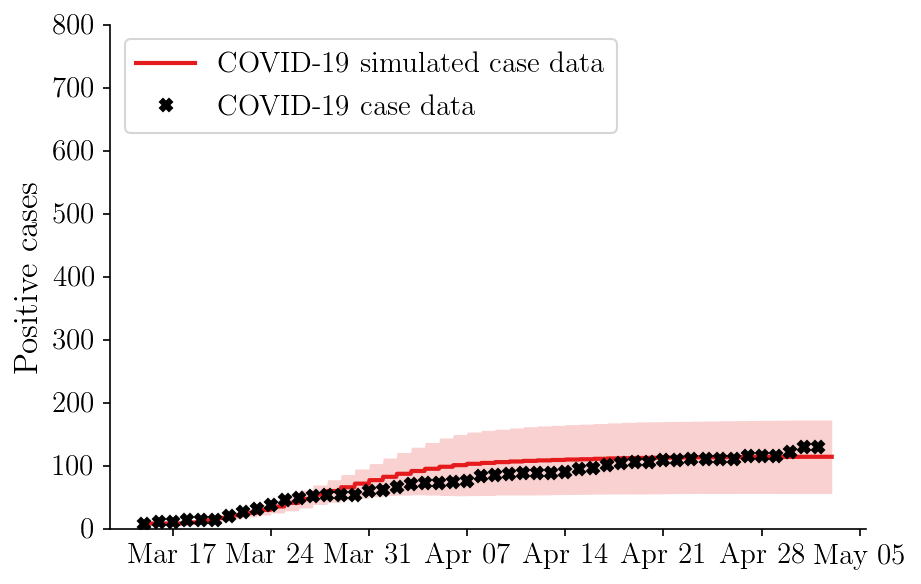

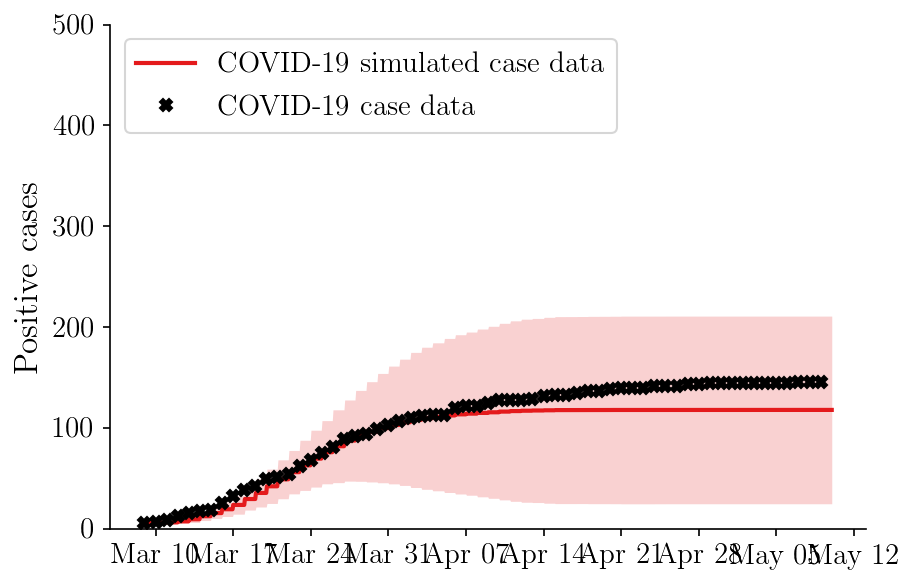

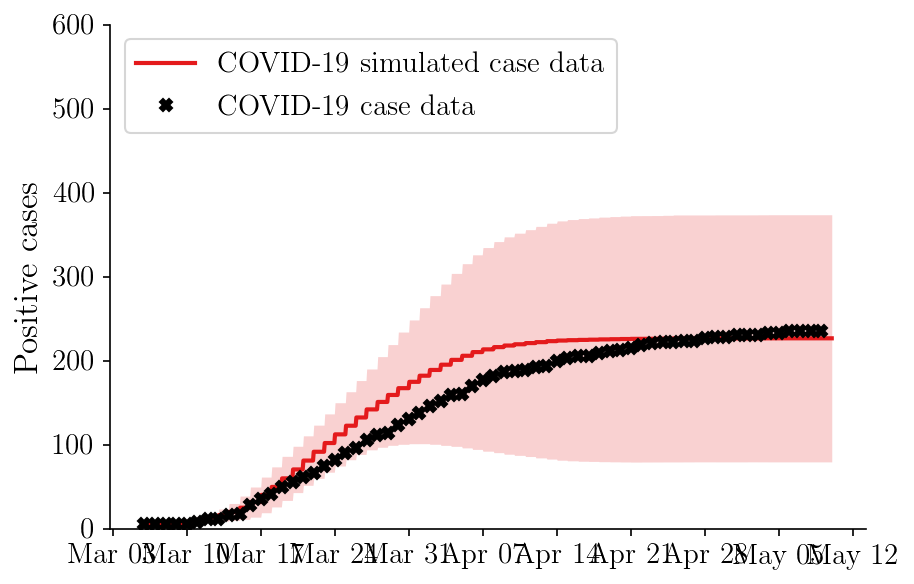

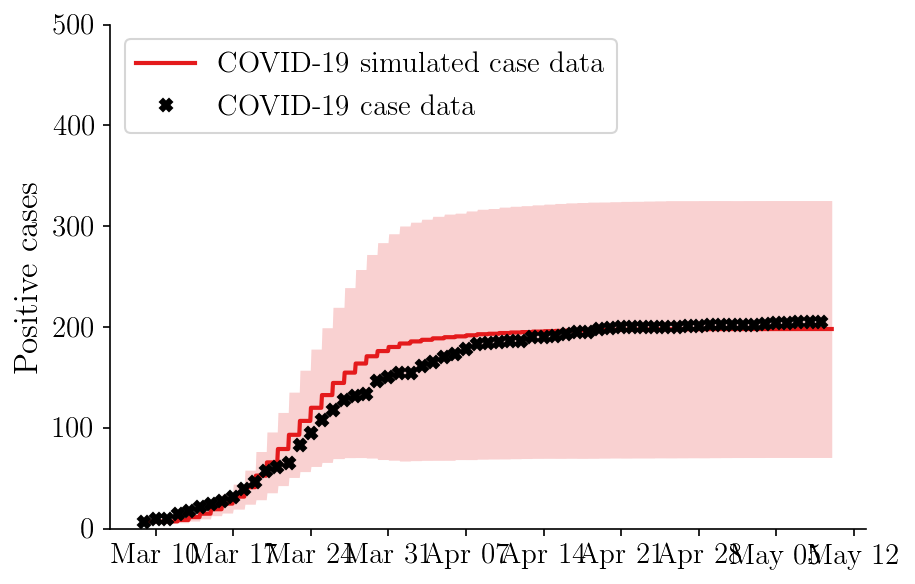

In [5]:
for country, area in places:
    print(country, area)
    try:
        plot_model_fit(country, area, ymax_modelfit)
    except FileNotFoundError:
        print(f'Summary not found.')

## Continued lockdown

In [6]:
def plot_continued_lockdown(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'continued-lockdown-{country}-{area}' : [
            Plot(label='Baseline',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Open after 2 weeks', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=2.pk')),
            Plot(label='Open after 4 weeks',
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=4.pk')),
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
        ],
    }


    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        end_date = calibration_lockdown_dates[sims[0].country]['end']

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.015,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)


GER TU
GER RH
GER KL
CH TI
CH BE
CH JU


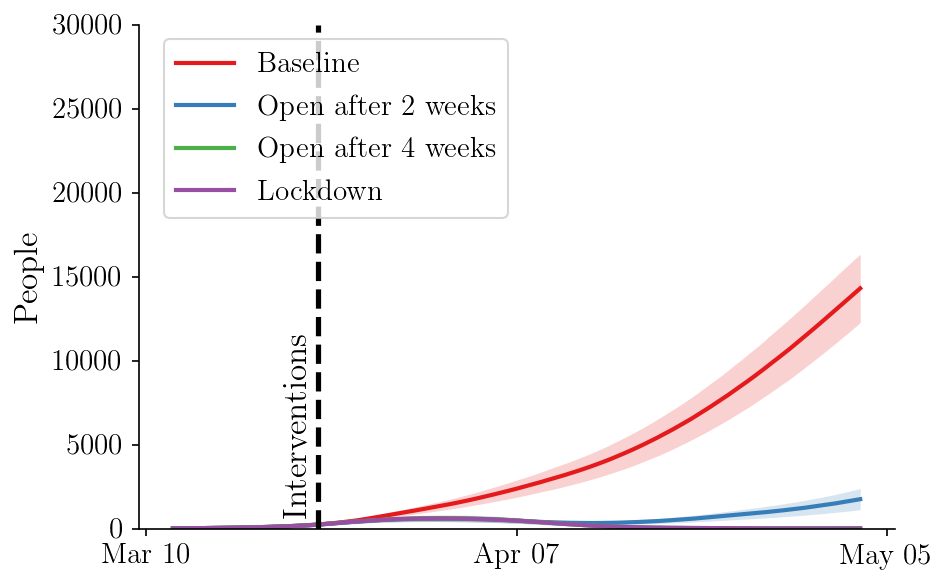

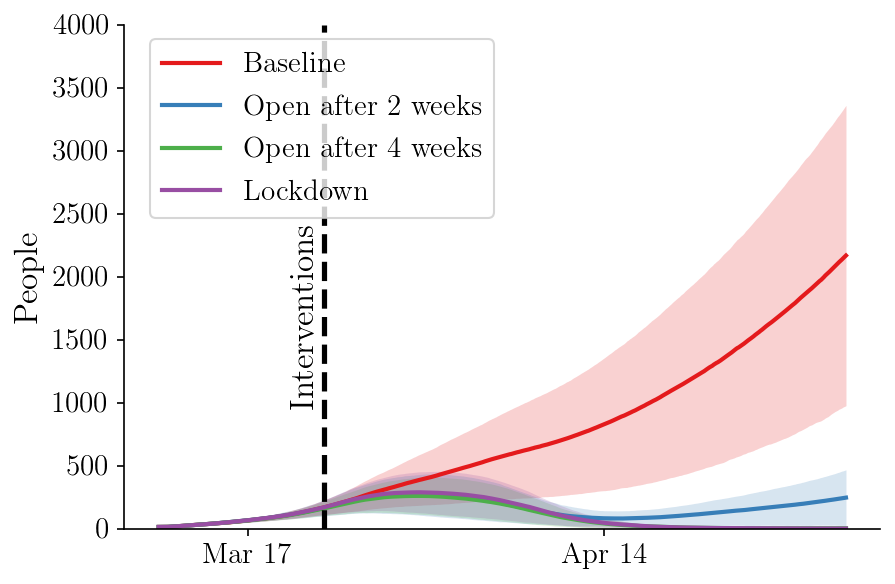

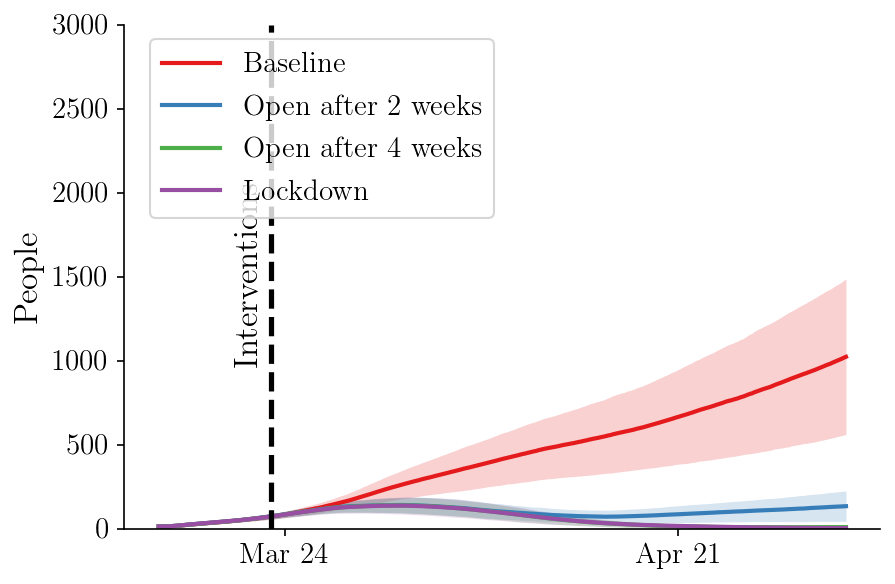

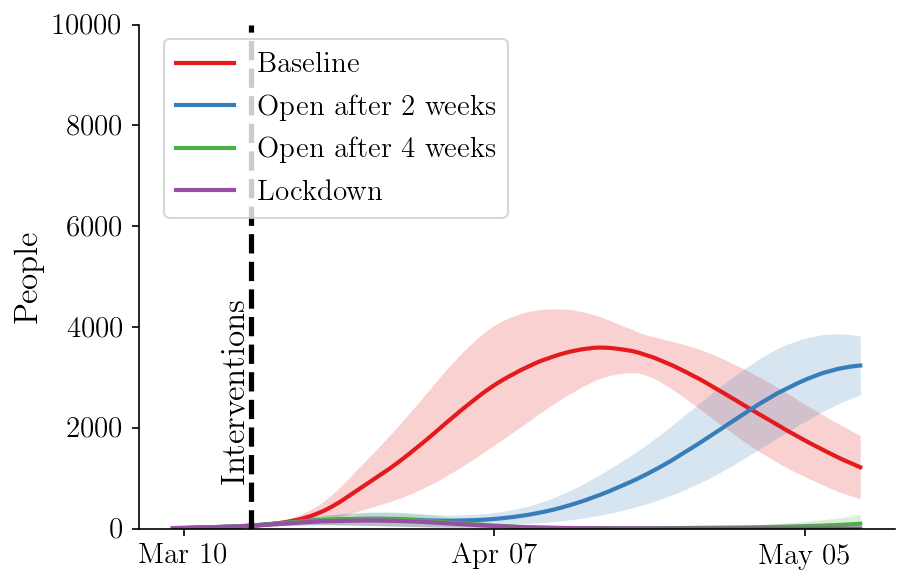

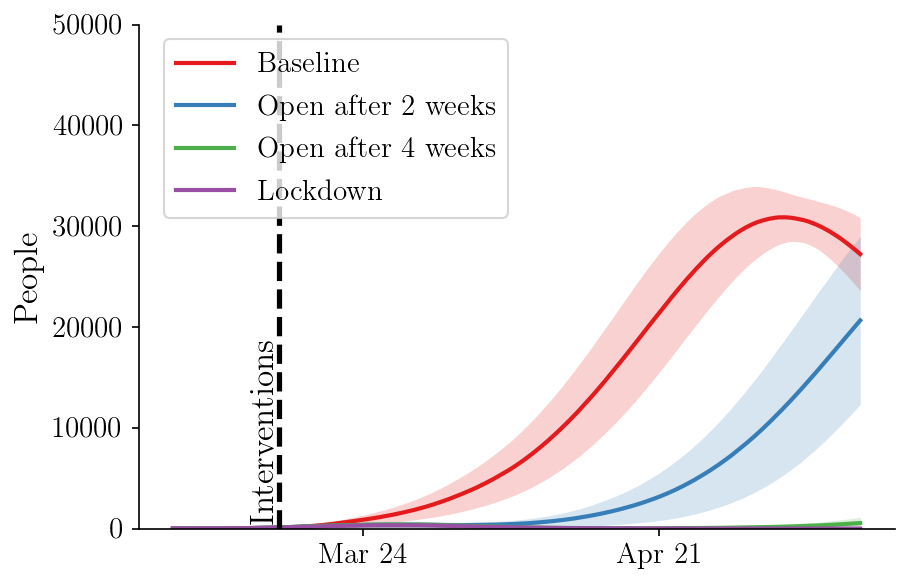

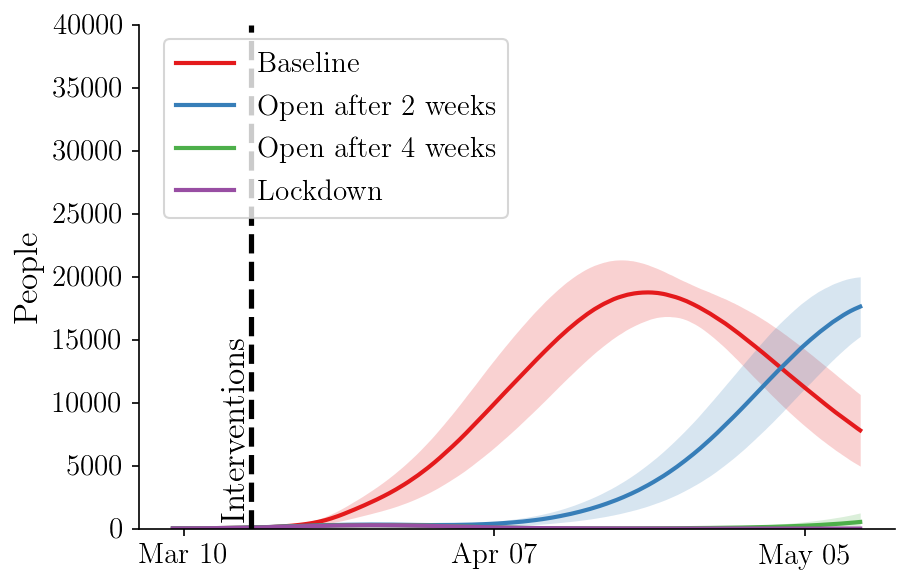

In [7]:
for country, area in places:
    print(country, area)
    try:
        plot_continued_lockdown(country, area, ymax_counterfactual)
    except FileNotFoundError:
        print(f'Summary not found.')

## K groups

In [8]:
def plot_k_groups(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'k-groups-{country}-{area}' : [
            Plot(label='Baseline', 
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='K = 2',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=2.pk')),
            Plot(label='K = 3',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=3.pk')),
            Plot(label='K = 4', 
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=4.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.015,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)



GER TU
GER RH
GER KL
CH TI
CH BE
CH JU


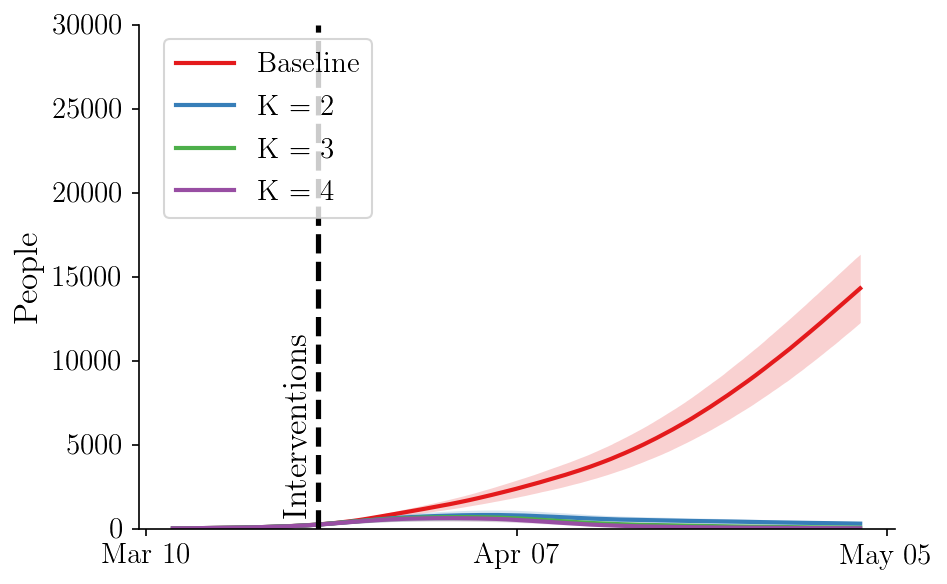

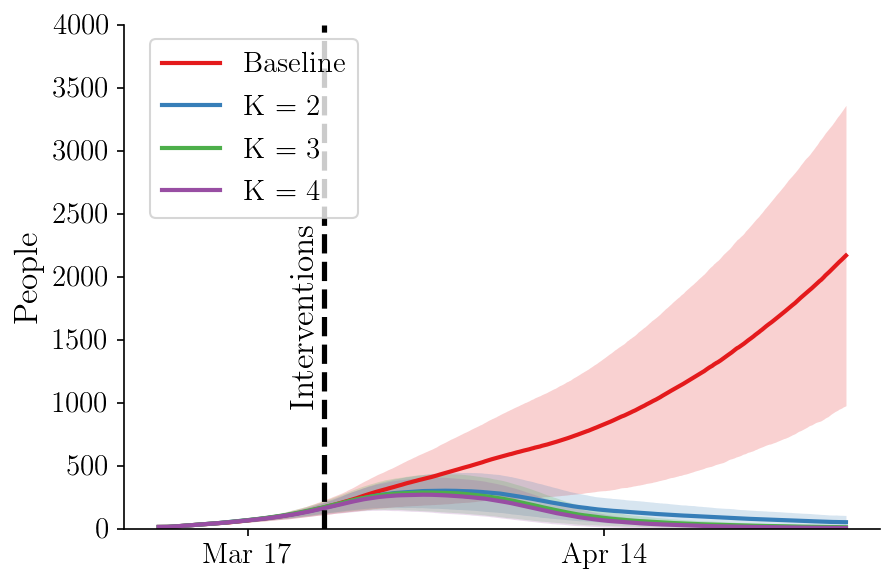

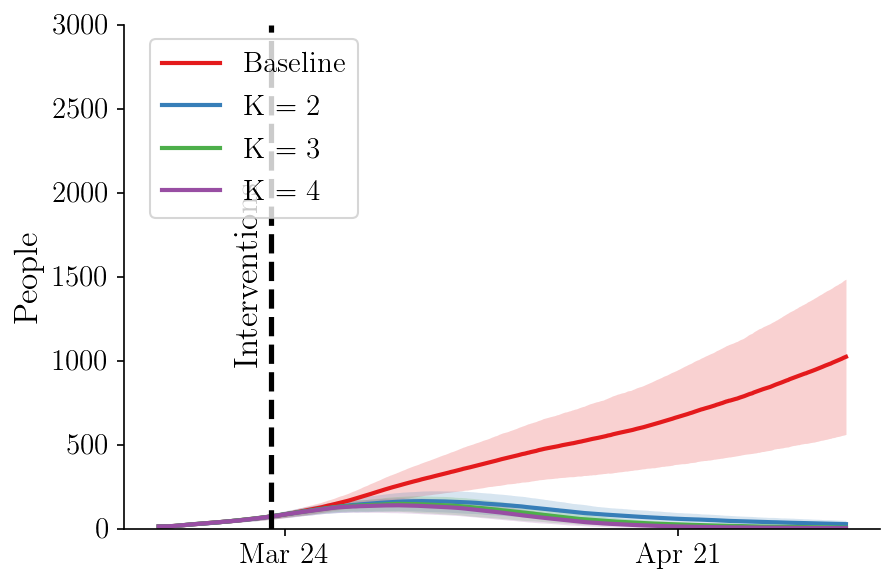

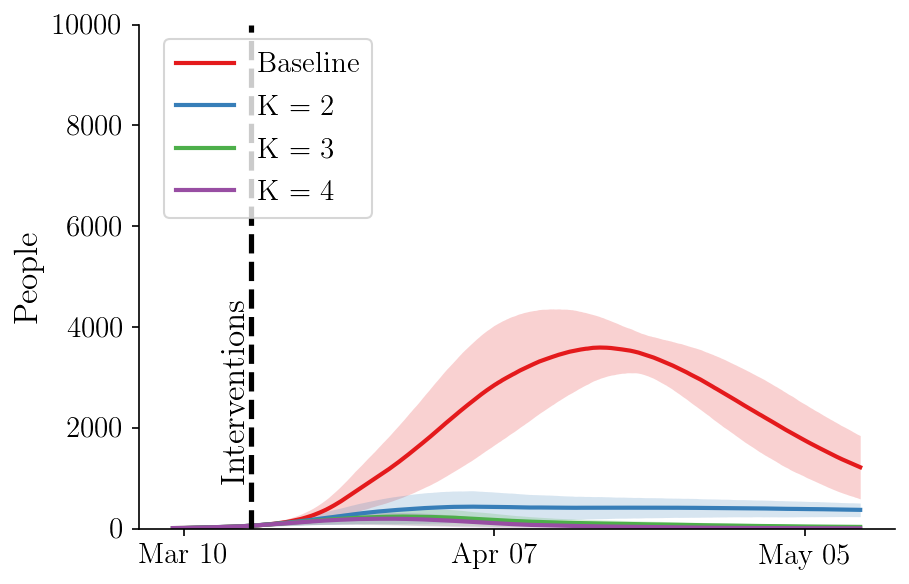

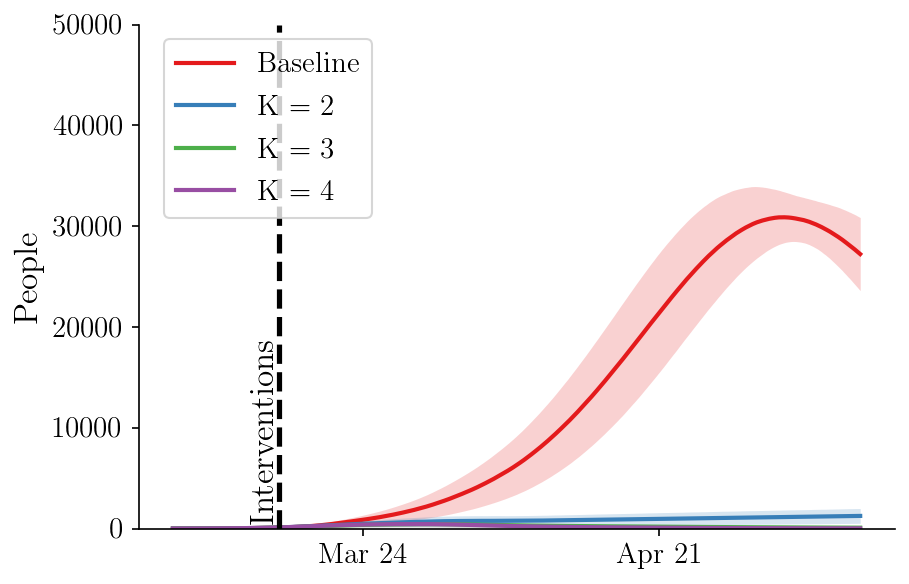

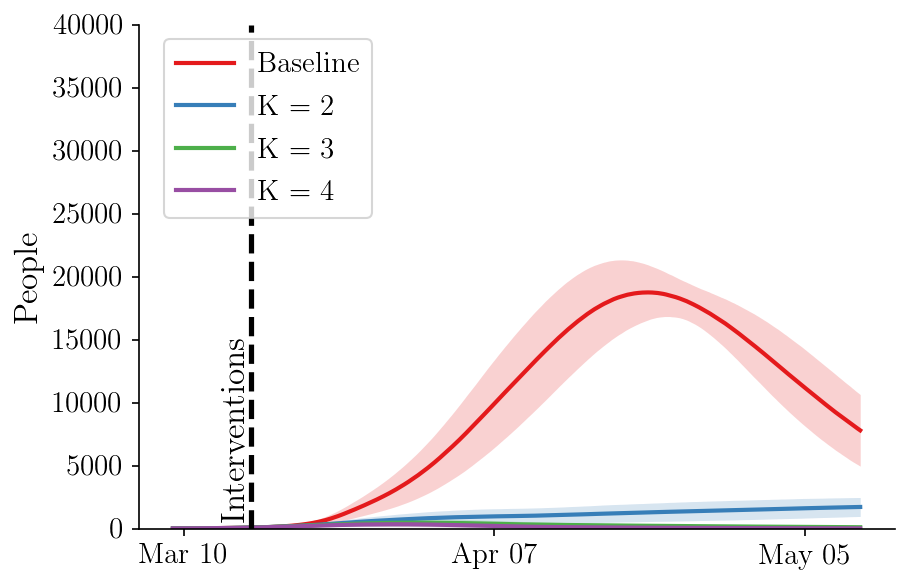

In [9]:
for country, area in places:
    print(country, area)
    try:
        plot_k_groups(country, area, ymax_counterfactual)
    except FileNotFoundError:
        print(f'Summary not found.')

## Vulnerable Groups


In [13]:
def plot_vulnerable_groups(country, area, ymax, ymax_hosp):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'vulnerable-groups-{country}-{area}' : [
            Plot(label='Baseline',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Vulnerable groups', 
                path=(f'vulnerable-groups-{country}-{area}/'
                      f'vulnerable-groups-{country}-{area}-.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.02,
            legendYoffset=0.02,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)

        plotter.compare_total_fatalities_and_hospitalizations(
            summaries, 
            titles=labels, 
            filename=plot_filename+ '-hosp', 
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legendXoffset=0.02,
            legendYoffset=0.02,
            legend_is_left=True,
            lockdown_at=days_until_lockdown,
            lockdown_label_y=50,
            lockdown_label='Interventions',
            ymax=ymax_hosp[sims[0].country][sims[0].area], 
            errorevery=14)

GER TU
GER RH
GER KL
CH TI
CH BE
CH JU


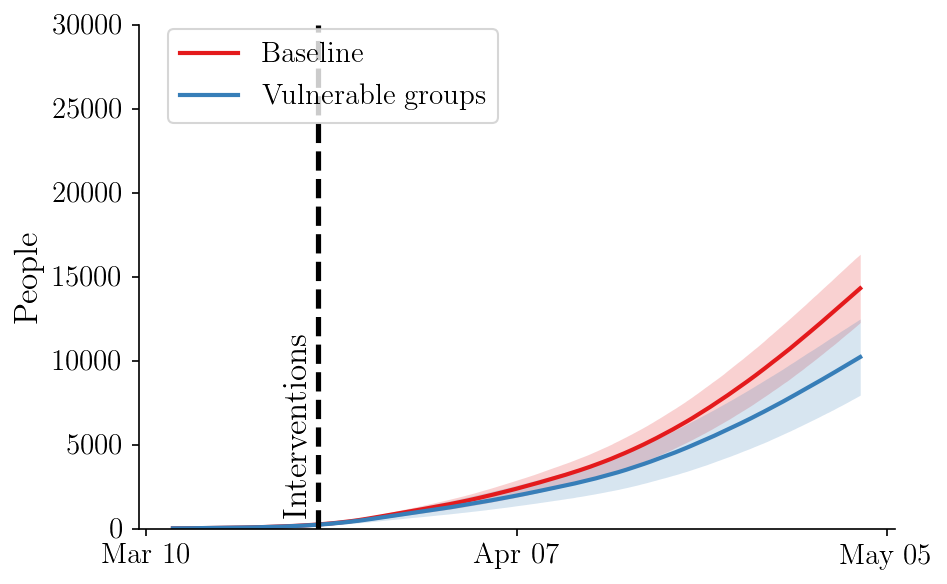

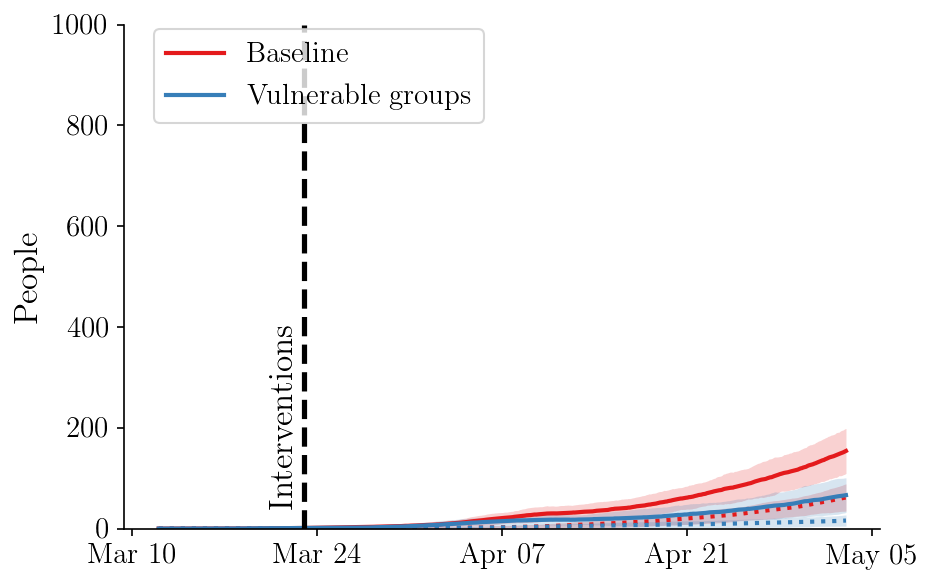

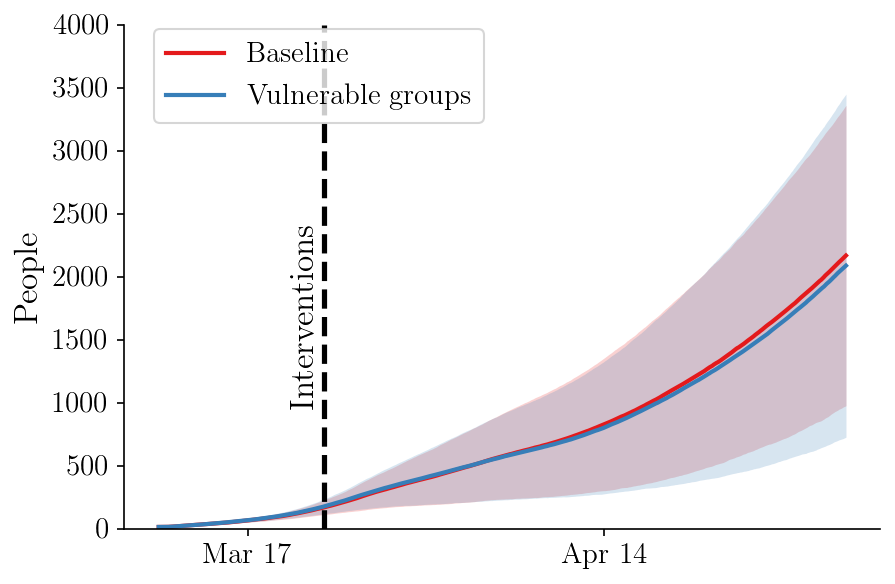

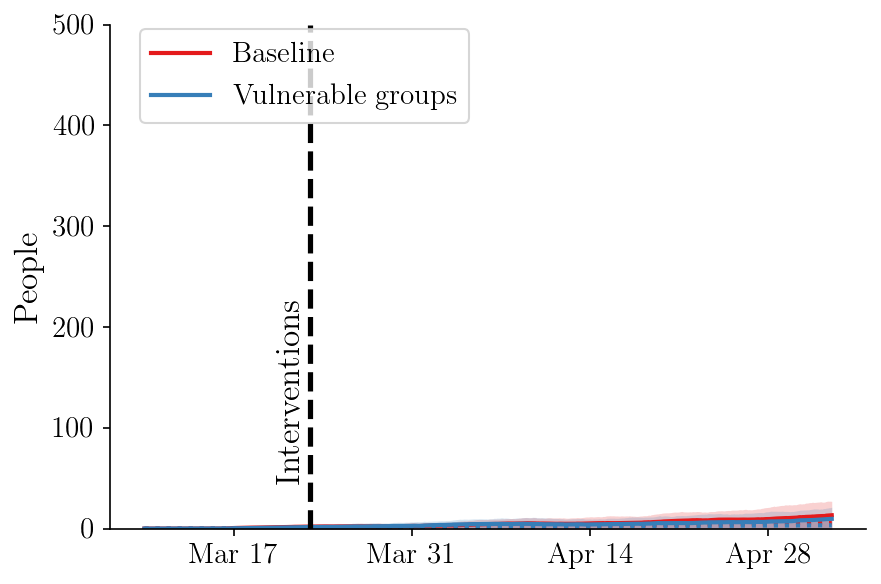

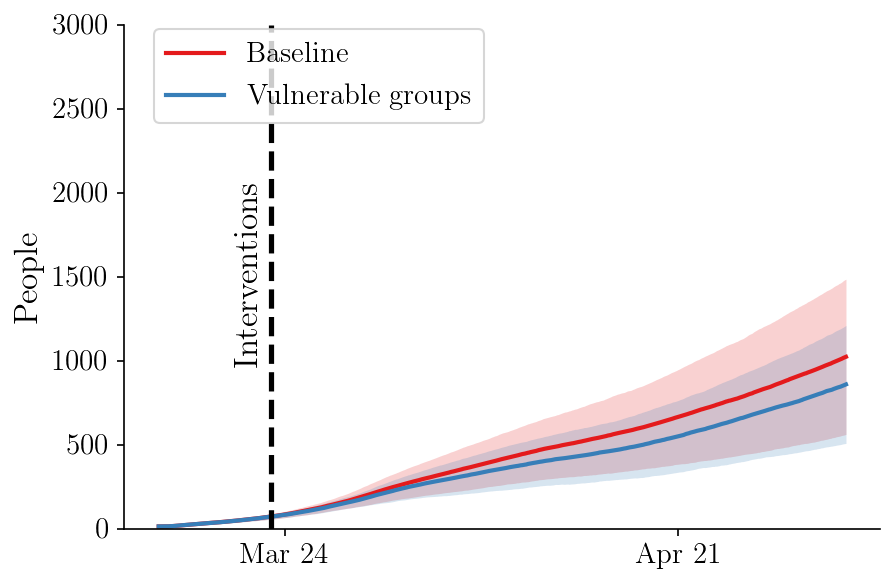

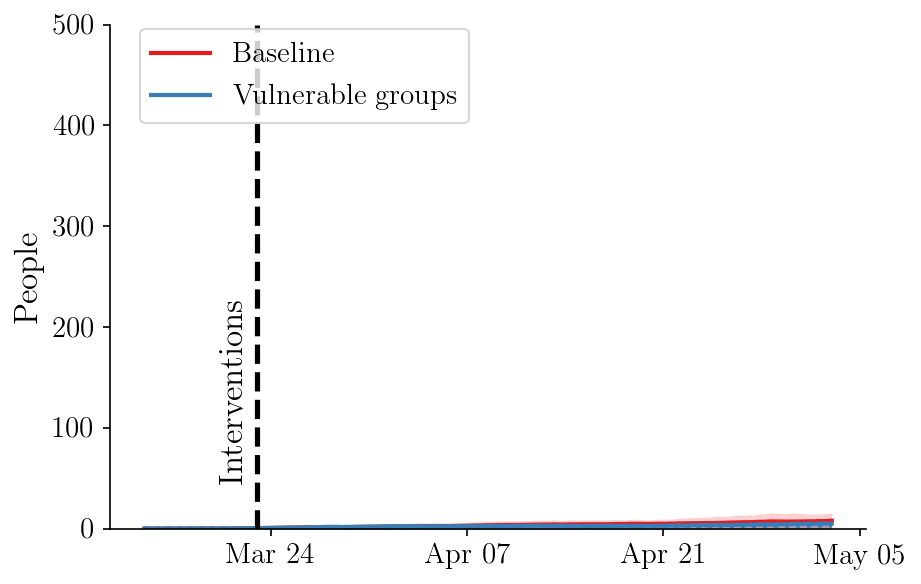

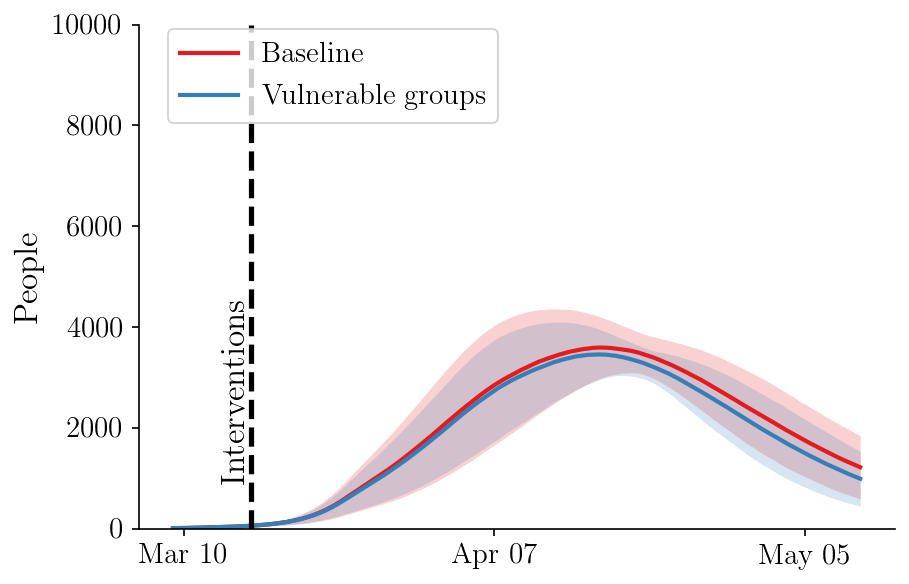

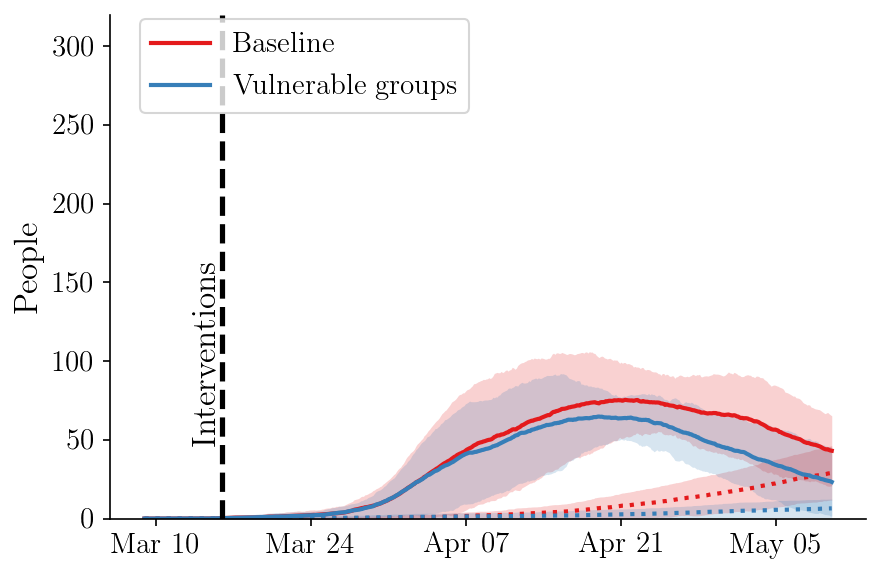

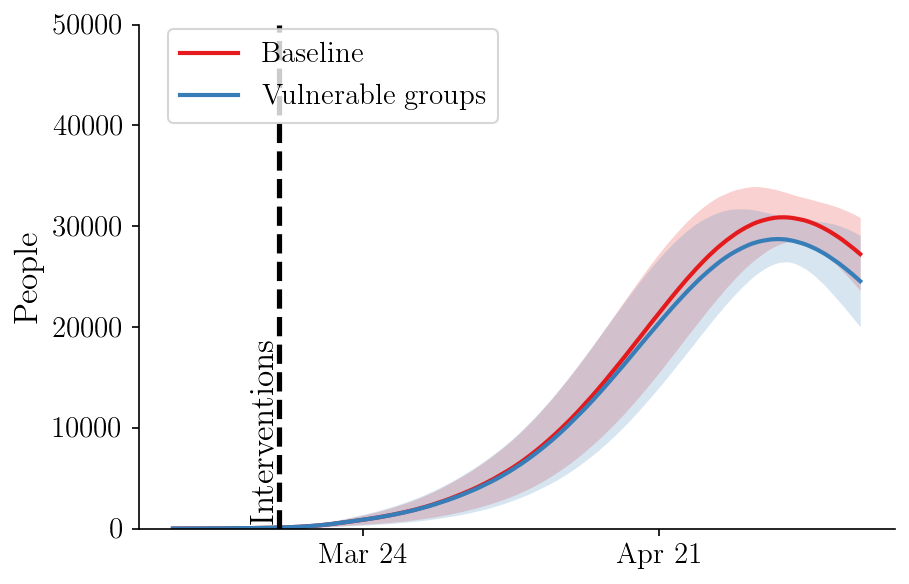

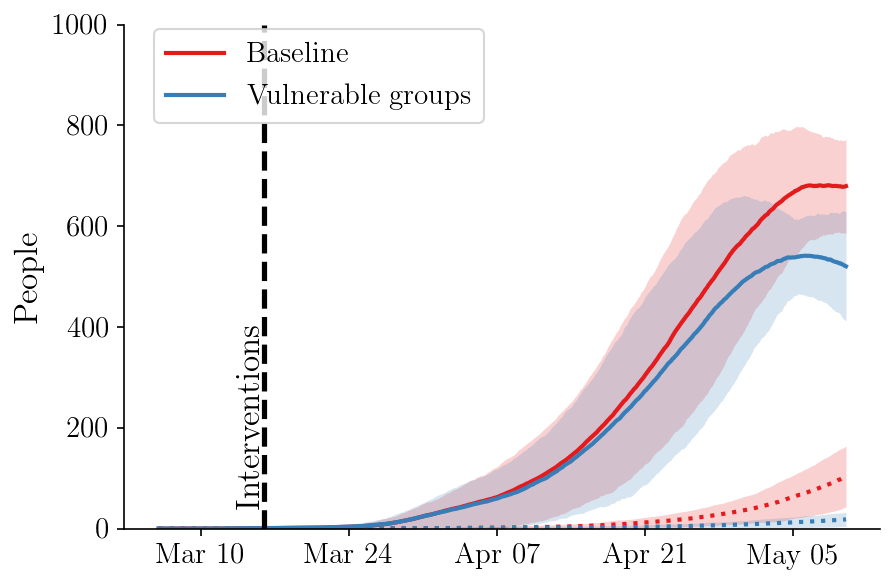

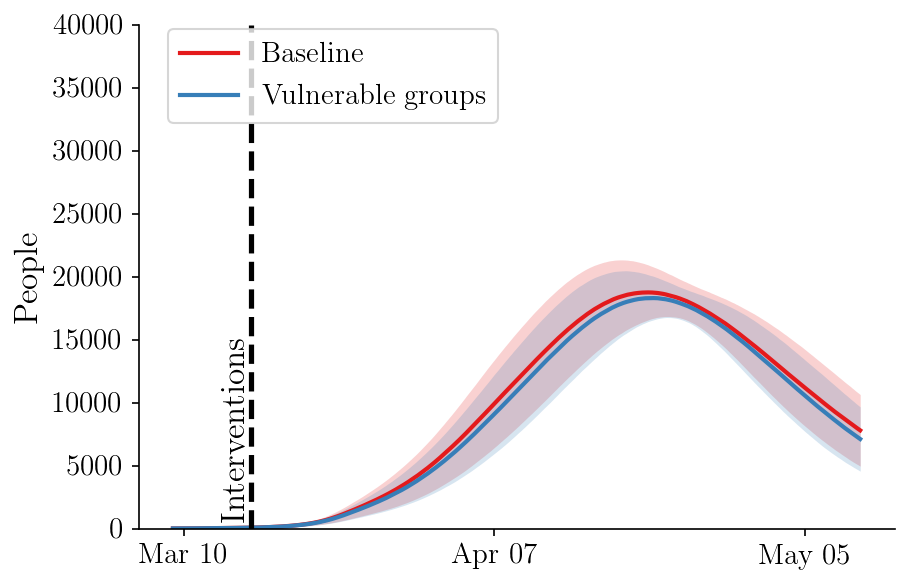

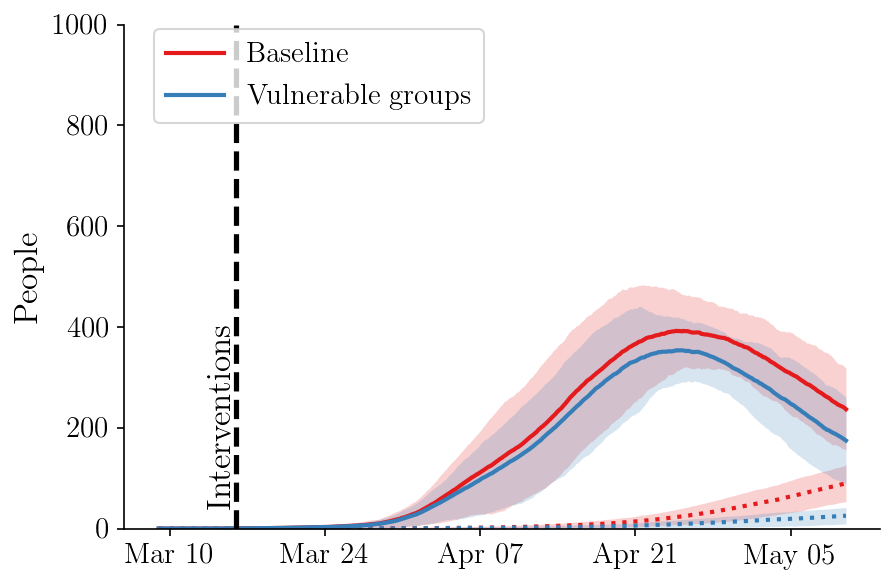

In [14]:
ymax_hosp = {
    'CH' : {'TI' : 320, 'BE': 1000, 'JU': 1000},
    'GER': {'TU': 400, 'KL': 50, 'RH': 50}
}

for country, area in places:
    print(country, area)
    try:
        plot_vulnerable_groups(country, area, ymax_counterfactual, ymax_hosp)
    except FileNotFoundError:
        print(f'Summary not found.')

### Contact tracing + Isolation

In [15]:
def plot_contact_tracing_isolation(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-{country}-{area}' : [
    #         Plot(label='baseline', 
    #             path=(f'baseline-scenario-b-{country}-{area}/'
    #                   f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='isolate+test, 48h delay, test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='isolate+test, 48h delay, only test top 30 risk',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=30-test_policy=advanced.pk')),
            Plot(label='isolate only, 48h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=48.0-contacts_tested=None-test_policy=None.pk')),
            Plot(label='isolate only, 3h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=3.0-contacts_tested=None-test_policy=None.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename + '-single', 
            show_single_runs=3,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area] / 2, 
            errorevery=14)



In [16]:
places = [('CH', 'TI')]

ymax = {
    'CH' : {'TI' : 150},
    'GER' : {'TU' : 200},
}

for country, area in places:
    print(country, area)
    try:
        plot_contact_tracing_isolation(country, area, ymax)
    except FileNotFoundError:
        print(f'Summary not found.')

CH TI
tracing-CH-TI/tracing-CH-TI-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk not found.
tracing-CH-TI/tracing-CH-TI-tracing=isolate+test-delay=48.0-contacts_tested=30-test_policy=advanced.pk not found.
tracing-CH-TI/tracing-CH-TI-tracing=isolate-delay=48.0-contacts_tested=None-test_policy=None.pk not found.
tracing-CH-TI/tracing-CH-TI-tracing=isolate-delay=3.0-contacts_tested=None-test_policy=None.pk not found.


IndexError: list index out of range

### Efficiency of advanced testing policy

In [ ]:
def plot_advanced_testing_policy(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-test-efficiency-{country}-{area}' : [
    #         Plot(label='baseline', 
    #             path=(f'baseline-scenario-b-{country}-{area}/'
    #                   f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='isolate+test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='isolate+test top 30 risk',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=30-test_policy=advanced.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

    #     plotter.compare_total_infections(
    #         summaries, 
    #         titles=labels, 
    #         filename=plot_filename, 
    #         show_single_runs=False,
    #         start_date=start_date,
    #         figsize=(6,4), acc=500, 
    #         legend_is_left=True,
    #         legendXoffset=0.015,
    #         ymax=ymax[sims[0].country][sims[0].area] / 2, 
    #         errorevery=14)

        for summary, label in zip(summaries, labels):
            plotter.plot_daily_tested(
                summary, 
                title=label, 
                filename=plot_filename + '-' + label, 
                figsize=(6,4), acc=500, 
                ymax=ymax[sim.country][sim.area], 
                errorevery=50)





In [ ]:
places = [('CH', 'TI')]

ymax = {
    'CH' : {'TI' : 5000},
    'GER' : {'TU' : 200}}

for country, area in places:
    print(country, area)
    try:
        plot_advanced_testing_policy(country, area, ymax)
    except FileNotFoundError:
        print(f'Summary not found.')

### Contact tracing + Isolation Compliance

In [ ]:
def plot_tracing_isolation_compliance(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-compliance-{country}-{area}' : [
            Plot(label='baseline', 
                path=(f'baseline-scenario-b-{country}-{area}/'
                      f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='25\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.25.pk')),
            Plot(label='50\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.5.pk')),
            Plot(label='65\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.65.pk')),
            Plot(label='75\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.75.pk')),
            Plot(label='100\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename + '-single', 
            show_single_runs=5,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area] * 1.5, 
            errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)



In [ ]:
places = [('CH', 'TI')]
# country, area = 'GER', 'TU'

ymax = {
    'CH' : {'TI' : 3000},
    'GER' : {'TU' : 200},
}

for country, area in places:
    print(country, area)
    try:
        plot_tracing_isolation_compliance(country, area, ymax)
    except FileNotFoundError:
        print(f'Summary not found.')

## Conditional Measures

In [40]:
def plot_conditional_measures(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'conditional-measures-scenario-b-{country}-{area}' : [
    #         Plot(label='Baseline', 
    #             path=(f'baseline-scenario-b-{country}-{area}/'
    #                   f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='conditional',
                path=(f'conditional-measures-scenario-b-{country}-{area}/'
                      f'conditional-measures-scenario-b-{country}-{area}-max_pos_tests_per_week_per_100k=50-initially_active=False.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename + '-single', 
            show_single_runs=10,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)



CH TI


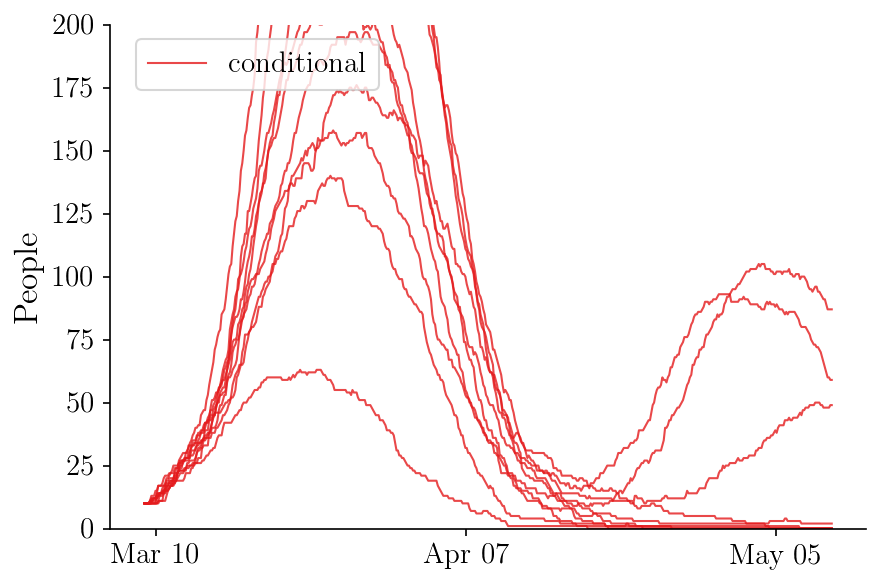

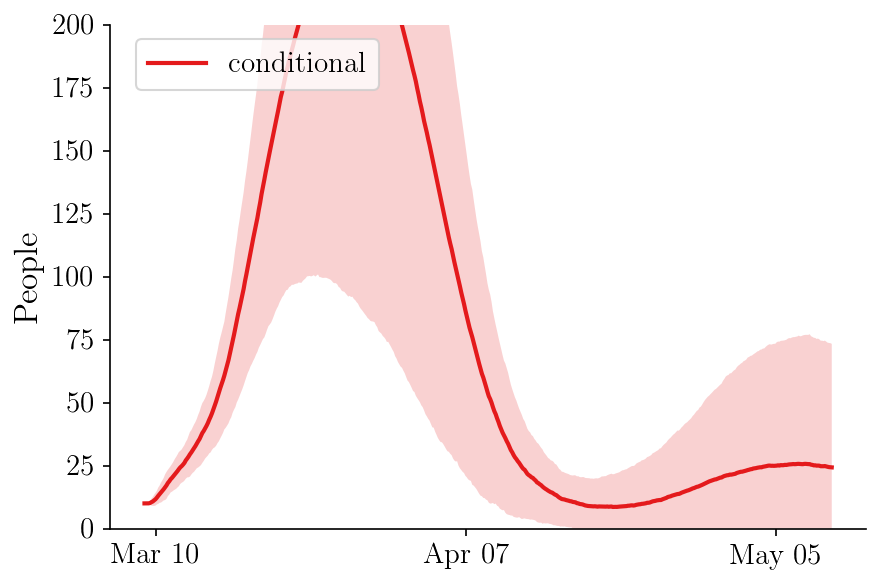

In [23]:
places = [('CH', 'TI')]

ymax = {
    'CH' : {'TI' : 200},
    'GER' : {'TU' : 500},
}

for country, area in places:
    print(country, area)
    try:
        plot_conditional_measures(country, area, ymax)
    except FileNotFoundError:
        print(f'Summary not found.')

## Other experiment

In [ ]:
plots = {
    # tbd
}

## Narrowcasting Plot

In [ ]:
from lib.town_maps import MapIllustrator
from lib.settings.town_settings_tubingen import bbox

In [ ]:
day_start = 7
day_duration = 14

In [ ]:
# make sure to load a summary file that had `store_mob = True`
summary = load_summary(f'summary_file_with_mob.pk')

# plot
ill = MapIllustrator()
ill.marker_radius = 10.0
map_name = f'narrowcasting-plot-{day_start}-{day_duration}'

sitemap = ill.empirical_infection_probability_map(
    bbox=bbox, 
    site_loc=mob.site_loc, 
    site_type=mob.site_type, 
    site_dict=mob.site_dict, 
    map_name=map_name, 
    sim=summary, 
    t0=TO_HOURS * day_start, 
    t1=TO_HOURS * (day_start + day_duration), 
    delta=0.0, 
    r=0)

In [ ]:
sitemap